In [1]:
!pip install einops

Defaulting to user installation because normal site-packages is not writeable


# Augmented Images with Hybrid CNN + Transformer

In [96]:
from PIL import Image
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np
import os


def load_images(*folder_paths, threshold=None):
    """
    Load mixed TIFF images (16-bit and RGB), normalize them to 8-bit grayscale [0-255].
    
    Args:
        folder_paths (str): Paths to the folders containing TIFF images.
        threshold (int, optional): Threshold value for binary masks. Default is None.

    Returns:
        np.ndarray: Array of 8-bit grayscale images normalized to [0-255].
    """
    images = []  # Store processed images

    for folder_path in folder_paths:
        tiff_files = [f for f in os.listdir(folder_path) if f.endswith('.tif') or f.endswith('.tiff')]

        for file_name in tiff_files:
            file_path = os.path.join(folder_path, file_name)

            # Load the image
            image = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)

            if image is None:
                print(f"Error loading {file_name}. Skipping.")
                continue

            # Normalize 16-bit images
            if image.dtype == np.uint16:
                min_val, max_val = np.min(image), np.max(image)
                if max_val > min_val:
                    image = ((image - min_val) / (max_val - min_val) * 255).astype(np.uint8)
                else:
                    image = np.zeros_like(image, dtype=np.uint8)

            # Convert RGB images to grayscale
            elif len(image.shape) == 3 and image.shape[-1] == 3:  # Check for RGB images
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

            # Thresholding for binary masks
            if threshold is not None:
                image = (image > threshold).astype(np.uint8)

            images.append(image)

    return np.stack(images)  # Return as a single NumPy array


In [97]:
# Paths to data
brightfield_folder = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_2/bacteria_counting/Data/2b/DeepBacs_Data_Segmentation_Staph_Aureus_dataset/brightfield_dataset/train/patches/brightfield'
masks_folder = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_2/bacteria_counting/Data/2b/DeepBacs_Data_Segmentation_Staph_Aureus_dataset/brightfield_dataset/train/patches/masks'

# Augmented images
augmented_brightfield_folder = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_2/bacteria_counting/Data/2b/DeepBacs_Data_Segmentation_Staph_Aureus_dataset/brightfield_dataset/train/patches/augmented_brightfield_dens_3'
augmented_masks_folder = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_2/bacteria_counting/Data/2b/DeepBacs_Data_Segmentation_Staph_Aureus_dataset/brightfield_dataset/train/patches/augmented_masks_dens_3'

# Load brightfield images and masks
original_brightfield = load_images(brightfield_folder, augmented_brightfield_folder)
original_masks = load_images(masks_folder, augmented_masks_folder, threshold=1)

# Convert images and masks to PyTorch tensors
X_tensor = torch.tensor(original_brightfield, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
Y_tensor = torch.tensor(original_masks, dtype=torch.float32).unsqueeze(1)  # Add channel dimension

dataset = TensorDataset(X_tensor, Y_tensor)  # Pairs of images and masks
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)  # Modify batch size if needed

#TODO: We need to add validation data!

# Check shapes
print(f"Original Brightfield Tensor Shape: {X_tensor.shape}")  # Expected: (batch_size, 1, H, W)
print(f"Original Masks Tensor Shape: {Y_tensor.shape}")        # Expected: (batch_size, 1, H, W)


Original Brightfield Tensor Shape: torch.Size([188, 1, 256, 256])
Original Masks Tensor Shape: torch.Size([188, 1, 256, 256])


In [98]:
# Test loader
# Paths to data
brightfield_folder_test = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_2/bacteria_counting/Data/2b/DeepBacs_Data_Segmentation_Staph_Aureus_dataset/brightfield_dataset/test/patches/brightfield'
masks_folder_test = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_2/bacteria_counting/Data/2b/DeepBacs_Data_Segmentation_Staph_Aureus_dataset/brightfield_dataset/test/patches/masks'

# Augmented images
augmented_brightfield_folder_test = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_2/bacteria_counting/Data/2b/DeepBacs_Data_Segmentation_Staph_Aureus_dataset/brightfield_dataset/test/patches/augmented_brightfield_dens_3'
augmented_masks_folder_test = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_2/bacteria_counting/Data/2b/DeepBacs_Data_Segmentation_Staph_Aureus_dataset/brightfield_dataset/test/patches/augmented_masks_dens_3'


# Load brightfield images and masks
original_brightfield_test = load_images(brightfield_folder_test, augmented_brightfield_folder_test)
original_masks_test = load_images(masks_folder_test, augmented_masks_folder_test, threshold=1)

# Convert images and masks to PyTorch tensors
X_tensor_test = torch.tensor(original_brightfield_test, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
Y_tensor_test = torch.tensor(original_masks_test, dtype=torch.float32).unsqueeze(1)  # Add channel dimension

test_dataset = TensorDataset(X_tensor_test, Y_tensor_test)  # Pairs of images and masks
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Check shapes
print(f"Original Brightfield Tensor Shape: {X_tensor_test.shape}")  # Expected: (batch_size, 1, H, W)
print(f"Original Masks Tensor Shape: {Y_tensor_test.shape}")        # Expected: (batch_size, 1, H, W)


Original Brightfield Tensor Shape: torch.Size([200, 1, 256, 256])
Original Masks Tensor Shape: torch.Size([200, 1, 256, 256])


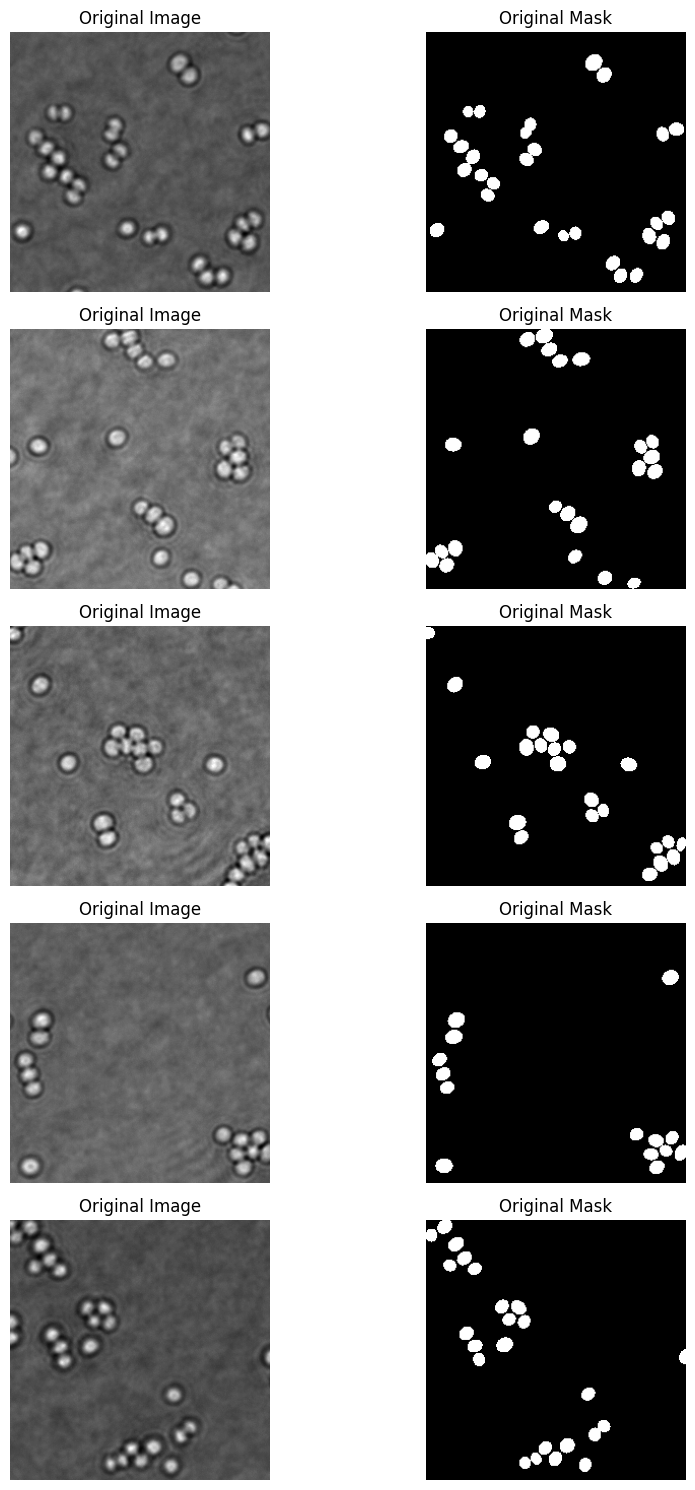

In [99]:
import matplotlib.pyplot as plt

num_examples = 5  # Number of examples to display
plt.figure(figsize=(10, num_examples * 3))

for i in range(num_examples):
    plt.subplot(num_examples, 2, i * 2 + 1)
    plt.imshow(original_brightfield_test[i], cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(num_examples, 2, i * 2 + 2)
    plt.imshow(original_masks_test[i], cmap="gray")
    plt.title("Original Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


### Inspect images

In [64]:
import cv2
import numpy as np
import os

def inspect_images(folder_path):
    """
    Inspect image properties: shape, data type, min/max pixel values.
    
    Args:
        folder_path (str): Path to the folder containing TIFF images.
    """
    tiff_files = [f for f in os.listdir(folder_path) if f.endswith('.tif') or f.endswith('.tiff')]
    
    for file_name in tiff_files:
        file_path = os.path.join(folder_path, file_name)
        
        # Read image as-is
        image = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
        
        # Print image properties
        print(f"File: {file_name}")
        print(f"  - Shape: {image.shape}")
        print(f"  - Data Type: {image.dtype}")
        print(f"  - Min Pixel Value: {image.min()}")
        print(f"  - Max Pixel Value: {image.max()}")
        print()
        
inspect_images(augmented_brightfield_folder_test)



File: augmented_0_JE2NileRed_oilp22_PMP_101220_011_1.tif
  - Shape: (256, 256, 3)
  - Data Type: uint8
  - Min Pixel Value: 22
  - Max Pixel Value: 124

File: augmented_3_JE2NileRed_oilp22_PMP_101220_007_3.tif
  - Shape: (256, 256, 3)
  - Data Type: uint8
  - Min Pixel Value: 21
  - Max Pixel Value: 113

File: augmented_5_JE2NileRed_oilp22_PMP_101220_008_3.tif
  - Shape: (256, 256, 3)
  - Data Type: uint8
  - Min Pixel Value: 23
  - Max Pixel Value: 125

File: augmented_6_JE2NileRed_oilp22_PMP_101220_010_4.tif
  - Shape: (256, 256, 3)
  - Data Type: uint8
  - Min Pixel Value: 21
  - Max Pixel Value: 112

File: augmented_1_JE2NileRed_oilp22_PMP_101220_010_3.tif
  - Shape: (256, 256, 3)
  - Data Type: uint8
  - Min Pixel Value: 20
  - Max Pixel Value: 110

File: augmented_1_JE2NileRed_oilp22_PMP_101220_010_4.tif
  - Shape: (256, 256, 3)
  - Data Type: uint8
  - Min Pixel Value: 21
  - Max Pixel Value: 99

File: augmented_8_JE2NileRed_oilp22_PMP_101220_007_1.tif
  - Shape: (256, 256, 3)
 

## CNN Feature Extractor

In [100]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self, output_channels=64):
        super(CNNFeatureExtractor, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # First Conv Layer
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Downsample by 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Second Conv Layer
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Downsample by 2
            nn.Conv2d(64, output_channels, kernel_size=3, stride=1, padding=1),  # Final Conv Layer
            nn.BatchNorm2d(output_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.cnn(x)
    

## Transformer

In [101]:
class SimpleTransformer(nn.Module):
    def __init__(self, img_size, patch_size, embed_dim, num_heads, num_layers, cnn_extractor):
        super(SimpleTransformer, self).__init__()
        self.cnn_extractor = cnn_extractor
        self.patch_size = patch_size
        self.embed_dim = embed_dim

        self.position_embedding = None
        self.transformer = nn.Transformer(embed_dim, num_heads, num_layers, num_layers)
        self.head = nn.Linear(embed_dim, patch_size * patch_size)

        # Upsampling layer to match target size
        self.upsample = nn.Upsample(scale_factor=0.5, mode='bilinear', align_corners=False)

    def forward(self, x):
        x = self.cnn_extractor(x)  # (B, C, H, W)
        B, C, H, W = x.shape
        #print(f"[DEBUG] CNN Output Shape: {x.shape}")

        x = rearrange(x, 'b c h w -> b (h w) c')  # (B, num_patches, embed_dim)
        num_patches = x.size(1)

        if self.position_embedding is None or self.position_embedding.size(1) != num_patches:
            self.position_embedding = nn.Parameter(torch.randn(1, num_patches, self.embed_dim).to(x.device))

        x = x + self.position_embedding
        x = self.transformer(x, x)
        #print(f"[DEBUG] Transformer Output Shape: {x.shape}")

        h_patches = w_patches = int(num_patches ** 0.5)
        x = self.head(x)
        x = rearrange(x, 'b (h_patches w_patches) (p1 p2) -> b 1 (h_patches p1) (w_patches p2)',
                      h_patches=h_patches, w_patches=w_patches, p1=self.patch_size, p2=self.patch_size)
        #print(f"[DEBUG] Rearranged Output Shape: {x.shape}")

        # Upsample to match target size
        x = self.upsample(x)
        #print(f"[DEBUG] Final Upsampled Output Shape: {x.shape}")
        return x

## Visualization Code

In [102]:
# Function to visualize predictions
def visualize_predictions(images, masks, outputs, num_examples=4):
    """
    Visualize a few examples of the input images, ground truth masks, and model predictions.

    Args:
        images (torch.Tensor): Input images.
        masks (torch.Tensor): Ground truth masks.
        outputs (torch.Tensor): Model predictions.
        num_examples (int): Number of examples to visualize.
    """
    # Convert tensors to CPU for visualization
    images = images[:num_examples].cpu().numpy()
    masks = masks[:num_examples].cpu().numpy()
    outputs = torch.sigmoid(outputs[:num_examples]).cpu().numpy()  # Apply sigmoid to get probabilities

    # Plot the results
    fig, axes = plt.subplots(num_examples, 3, figsize=(12, num_examples * 4))
    for i in range(num_examples):
        # Input image
        axes[i, 0].imshow(images[i, 0], cmap="gray")
        axes[i, 0].set_title("Input Image")
        axes[i, 0].axis("off")

        # Ground truth mask
        axes[i, 1].imshow(masks[i, 0], cmap="gray")
        axes[i, 1].set_title("Ground Truth Mask")
        axes[i, 1].axis("off")

        # Model prediction
        axes[i, 2].imshow(outputs[i, 0], cmap="gray")
        axes[i, 2].set_title("Model Prediction")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

## Training

Epoch 1, Train Loss: 0.5722, Test Loss: 0.5436
Epoch 2, Train Loss: 0.5106, Test Loss: 0.5146
Epoch 3, Train Loss: 0.4781, Test Loss: 0.4906
Epoch 4, Train Loss: 0.4509, Test Loss: 0.4711
Epoch 5, Train Loss: 0.4286, Test Loss: 0.4557
Epoch 6, Train Loss: 0.4105, Test Loss: 0.4433
Epoch 7, Train Loss: 0.3896, Test Loss: 0.3868
Epoch 8, Train Loss: 0.3054, Test Loss: 0.3012
Epoch 9, Train Loss: 0.2532, Test Loss: 0.2478
Epoch 10, Train Loss: 0.2253, Test Loss: 0.2255
Epoch 11, Train Loss: 0.2052, Test Loss: 0.2065
Epoch 12, Train Loss: 0.1836, Test Loss: 0.1886
Epoch 13, Train Loss: 0.1672, Test Loss: 0.1679
Epoch 14, Train Loss: 0.1544, Test Loss: 0.1584
Epoch 15, Train Loss: 0.1434, Test Loss: 0.1511
Epoch 16, Train Loss: 0.1346, Test Loss: 0.1384
Epoch 17, Train Loss: 0.1260, Test Loss: 0.1304
Epoch 18, Train Loss: 0.1203, Test Loss: 0.1266
Epoch 19, Train Loss: 0.1133, Test Loss: 0.1212
Epoch 20, Train Loss: 0.1073, Test Loss: 0.1142
Epoch 21, Train Loss: 0.1026, Test Loss: 0.1102
E

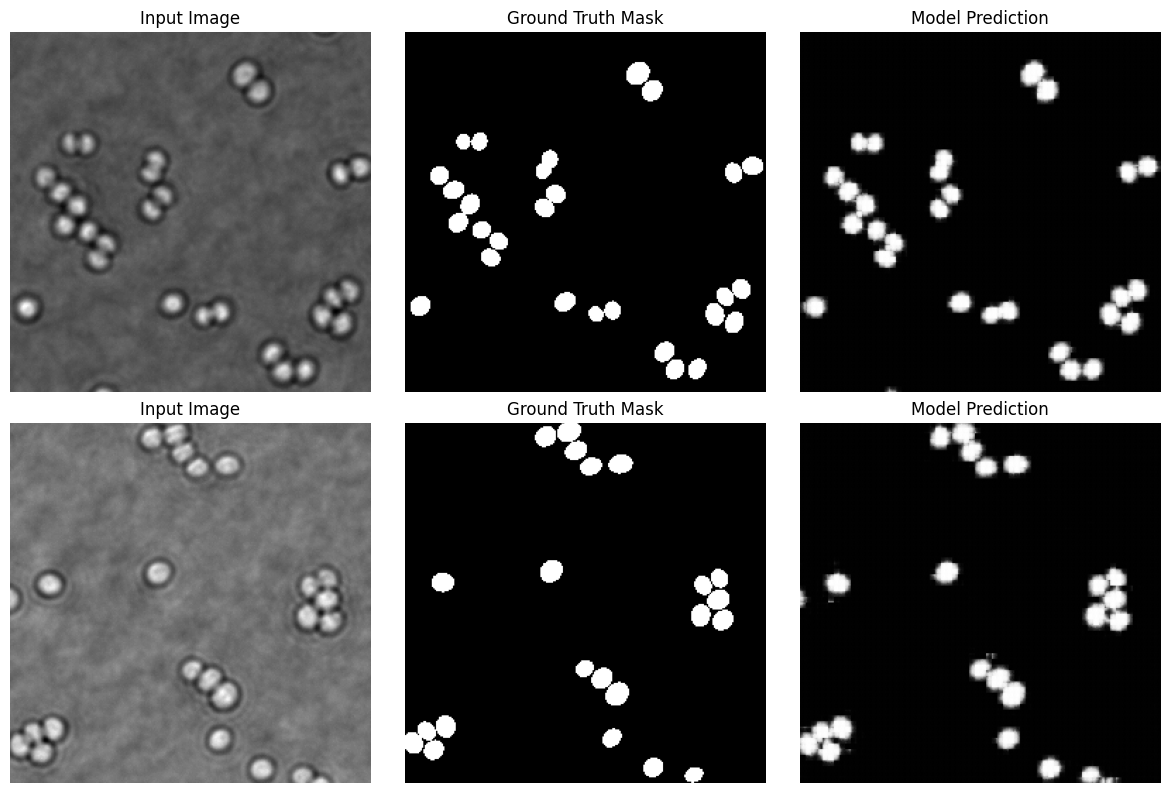

Epoch 51, Train Loss: 0.0516, Test Loss: 0.0580
Epoch 52, Train Loss: 0.0506, Test Loss: 0.0587
Epoch 53, Train Loss: 0.0493, Test Loss: 0.0574
Epoch 54, Train Loss: 0.0485, Test Loss: 0.0588
Epoch 55, Train Loss: 0.0486, Test Loss: 0.0564
Epoch 56, Train Loss: 0.0470, Test Loss: 0.0553
Epoch 57, Train Loss: 0.0465, Test Loss: 0.0545
Epoch 58, Train Loss: 0.0462, Test Loss: 0.0545
Epoch 59, Train Loss: 0.0457, Test Loss: 0.0538
Epoch 60, Train Loss: 0.0451, Test Loss: 0.0525
Epoch 61, Train Loss: 0.0447, Test Loss: 0.0520
Epoch 62, Train Loss: 0.0440, Test Loss: 0.0516
Epoch 63, Train Loss: 0.0432, Test Loss: 0.0517
Epoch 64, Train Loss: 0.0426, Test Loss: 0.0512
Epoch 65, Train Loss: 0.0426, Test Loss: 0.0492
Epoch 66, Train Loss: 0.0424, Test Loss: 0.0512
Epoch 67, Train Loss: 0.0416, Test Loss: 0.0499
Epoch 68, Train Loss: 0.0414, Test Loss: 0.0506
Epoch 69, Train Loss: 0.0403, Test Loss: 0.0509
Epoch 70, Train Loss: 0.0404, Test Loss: 0.0488
Epoch 71, Train Loss: 0.0398, Test Loss:

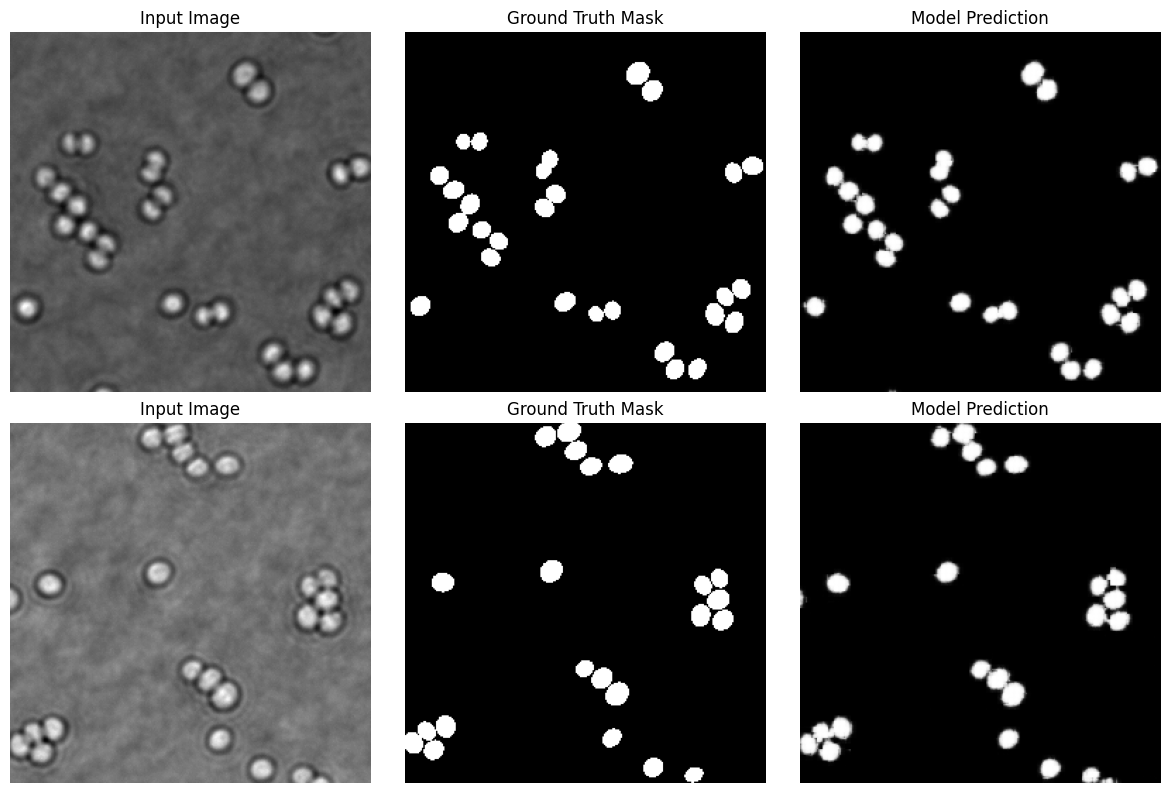

Epoch 101, Train Loss: 0.0315, Test Loss: 0.0369
Epoch 102, Train Loss: 0.0307, Test Loss: 0.0370
Epoch 103, Train Loss: 0.0302, Test Loss: 0.0373
Epoch 104, Train Loss: 0.0301, Test Loss: 0.0367
Epoch 105, Train Loss: 0.0305, Test Loss: 0.0359
Epoch 106, Train Loss: 0.0297, Test Loss: 0.0355
Epoch 107, Train Loss: 0.0293, Test Loss: 0.0369
Epoch 108, Train Loss: 0.0292, Test Loss: 0.0348
Epoch 109, Train Loss: 0.0292, Test Loss: 0.0366
Epoch 110, Train Loss: 0.0288, Test Loss: 0.0356
Epoch 111, Train Loss: 0.0287, Test Loss: 0.0361
Epoch 112, Train Loss: 0.0285, Test Loss: 0.0345
Epoch 113, Train Loss: 0.0283, Test Loss: 0.0381
Epoch 114, Train Loss: 0.0287, Test Loss: 0.0352
Epoch 115, Train Loss: 0.0283, Test Loss: 0.0375
Epoch 116, Train Loss: 0.0282, Test Loss: 0.0371
Epoch 117, Train Loss: 0.0289, Test Loss: 0.0343
Epoch 118, Train Loss: 0.0279, Test Loss: 0.0332
Epoch 119, Train Loss: 0.0278, Test Loss: 0.0343
Epoch 120, Train Loss: 0.0280, Test Loss: 0.0334
Epoch 121, Train Los

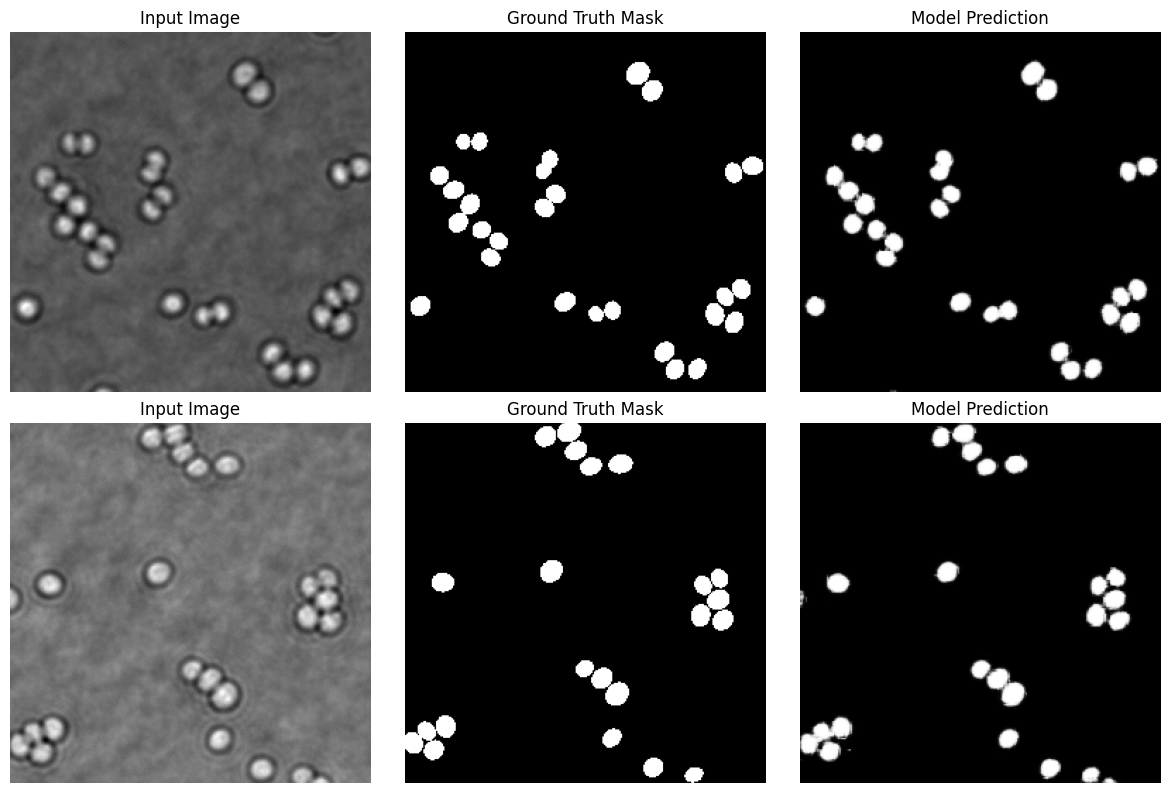

Epoch 151, Train Loss: 0.0230, Test Loss: 0.0285
Epoch 152, Train Loss: 0.0229, Test Loss: 0.0298
Epoch 153, Train Loss: 0.0224, Test Loss: 0.0283
Epoch 154, Train Loss: 0.0225, Test Loss: 0.0288
Epoch 155, Train Loss: 0.0224, Test Loss: 0.0290
Epoch 156, Train Loss: 0.0220, Test Loss: 0.0282
Epoch 157, Train Loss: 0.0219, Test Loss: 0.0283
Epoch 158, Train Loss: 0.0218, Test Loss: 0.0278
Epoch 159, Train Loss: 0.0220, Test Loss: 0.0280
Epoch 160, Train Loss: 0.0222, Test Loss: 0.0275
Epoch 161, Train Loss: 0.0220, Test Loss: 0.0293
Epoch 162, Train Loss: 0.0222, Test Loss: 0.0298
Epoch 163, Train Loss: 0.0218, Test Loss: 0.0274
Epoch 164, Train Loss: 0.0216, Test Loss: 0.0275
Epoch 165, Train Loss: 0.0211, Test Loss: 0.0287
Epoch 166, Train Loss: 0.0214, Test Loss: 0.0287
Epoch 167, Train Loss: 0.0210, Test Loss: 0.0275
Epoch 168, Train Loss: 0.0210, Test Loss: 0.0271
Epoch 169, Train Loss: 0.0212, Test Loss: 0.0274
Epoch 170, Train Loss: 0.0209, Test Loss: 0.0278
Epoch 171, Train Los

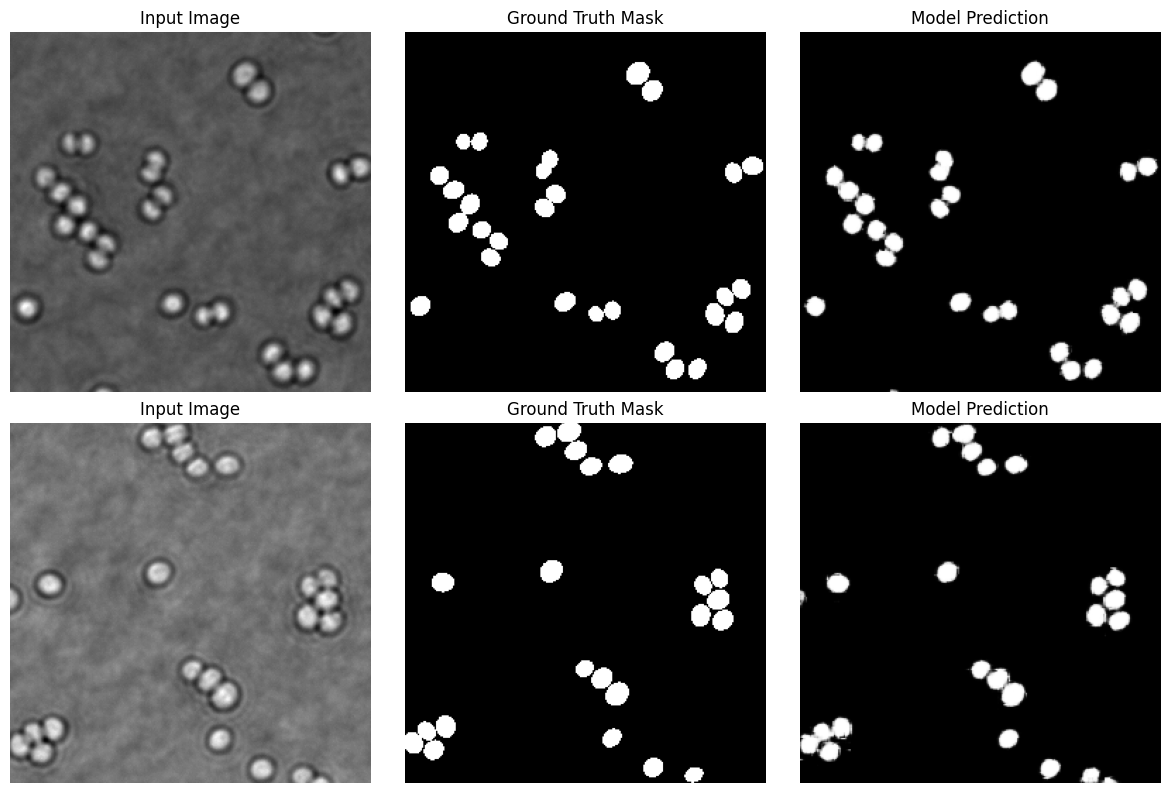

Epoch 201, Train Loss: 0.0180, Test Loss: 0.0245
Epoch 202, Train Loss: 0.0180, Test Loss: 0.0242
Epoch 203, Train Loss: 0.0180, Test Loss: 0.0252
Epoch 204, Train Loss: 0.0179, Test Loss: 0.0261
Epoch 205, Train Loss: 0.0179, Test Loss: 0.0260
Epoch 206, Train Loss: 0.0179, Test Loss: 0.0263
Epoch 207, Train Loss: 0.0180, Test Loss: 0.0263
Epoch 208, Train Loss: 0.0176, Test Loss: 0.0254
Epoch 209, Train Loss: 0.0174, Test Loss: 0.0248
Epoch 210, Train Loss: 0.0178, Test Loss: 0.0240
Epoch 211, Train Loss: 0.0175, Test Loss: 0.0243
Epoch 212, Train Loss: 0.0178, Test Loss: 0.0259
Epoch 213, Train Loss: 0.0180, Test Loss: 0.0235
Epoch 214, Train Loss: 0.0181, Test Loss: 0.0241
Epoch 215, Train Loss: 0.0178, Test Loss: 0.0260
Epoch 216, Train Loss: 0.0174, Test Loss: 0.0271
Epoch 217, Train Loss: 0.0176, Test Loss: 0.0259
Epoch 218, Train Loss: 0.0171, Test Loss: 0.0243
Epoch 219, Train Loss: 0.0168, Test Loss: 0.0240
Epoch 220, Train Loss: 0.0173, Test Loss: 0.0238
Epoch 221, Train Los

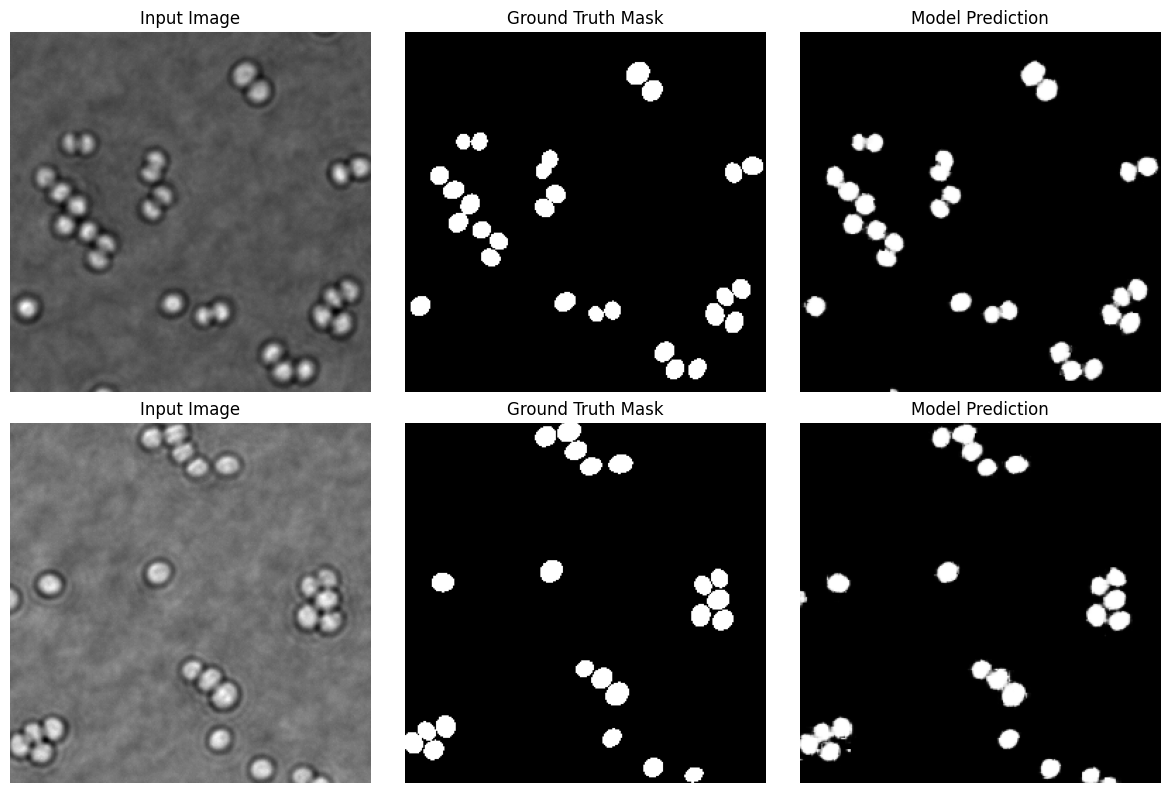

Epoch 251, Train Loss: 0.0156, Test Loss: 0.0224
Epoch 252, Train Loss: 0.0151, Test Loss: 0.0228
Epoch 253, Train Loss: 0.0149, Test Loss: 0.0237
Epoch 254, Train Loss: 0.0153, Test Loss: 0.0217
Epoch 255, Train Loss: 0.0154, Test Loss: 0.0232
Epoch 256, Train Loss: 0.0150, Test Loss: 0.0223
Epoch 257, Train Loss: 0.0147, Test Loss: 0.0218
Epoch 258, Train Loss: 0.0146, Test Loss: 0.0221
Epoch 259, Train Loss: 0.0145, Test Loss: 0.0220
Epoch 260, Train Loss: 0.0146, Test Loss: 0.0222
Epoch 261, Train Loss: 0.0143, Test Loss: 0.0218
Epoch 262, Train Loss: 0.0145, Test Loss: 0.0223
Epoch 263, Train Loss: 0.0143, Test Loss: 0.0217
Epoch 264, Train Loss: 0.0146, Test Loss: 0.0234
Epoch 265, Train Loss: 0.0148, Test Loss: 0.0224
Epoch 266, Train Loss: 0.0158, Test Loss: 0.0240
Epoch 267, Train Loss: 0.0147, Test Loss: 0.0216
Epoch 268, Train Loss: 0.0146, Test Loss: 0.0243
Epoch 269, Train Loss: 0.0143, Test Loss: 0.0226
Epoch 270, Train Loss: 0.0139, Test Loss: 0.0219
Epoch 271, Train Los

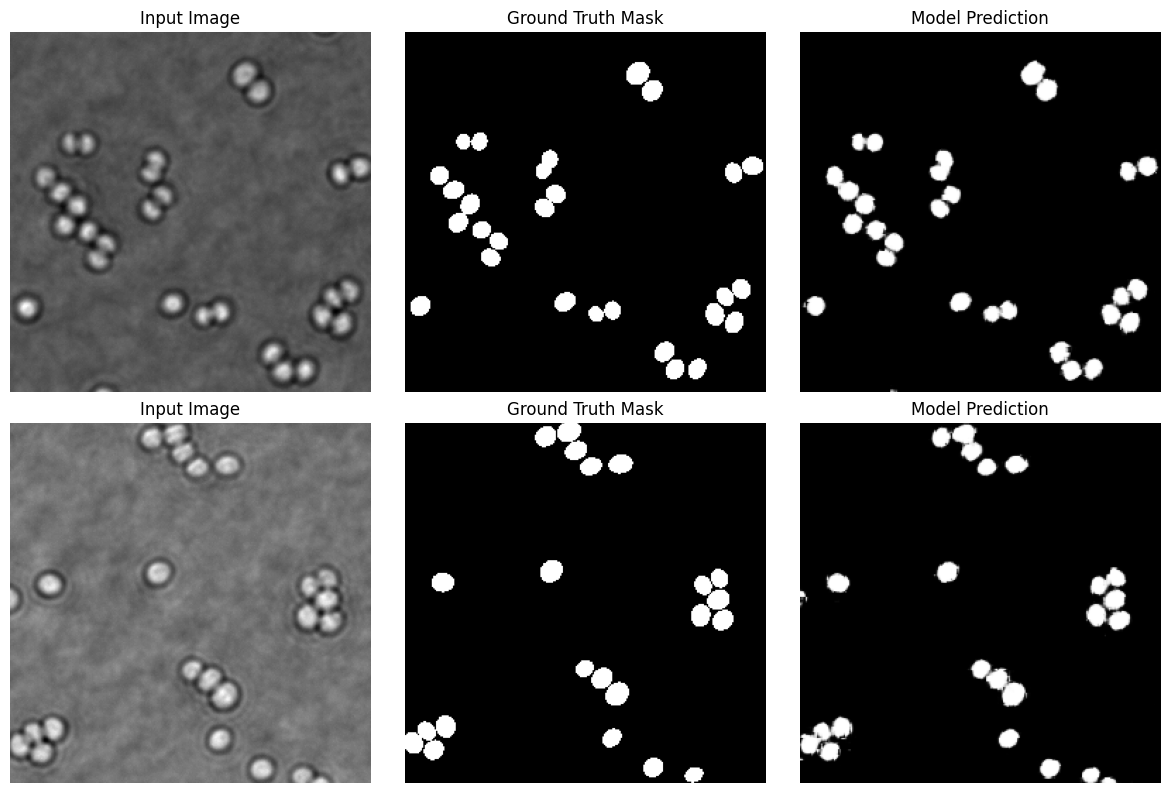

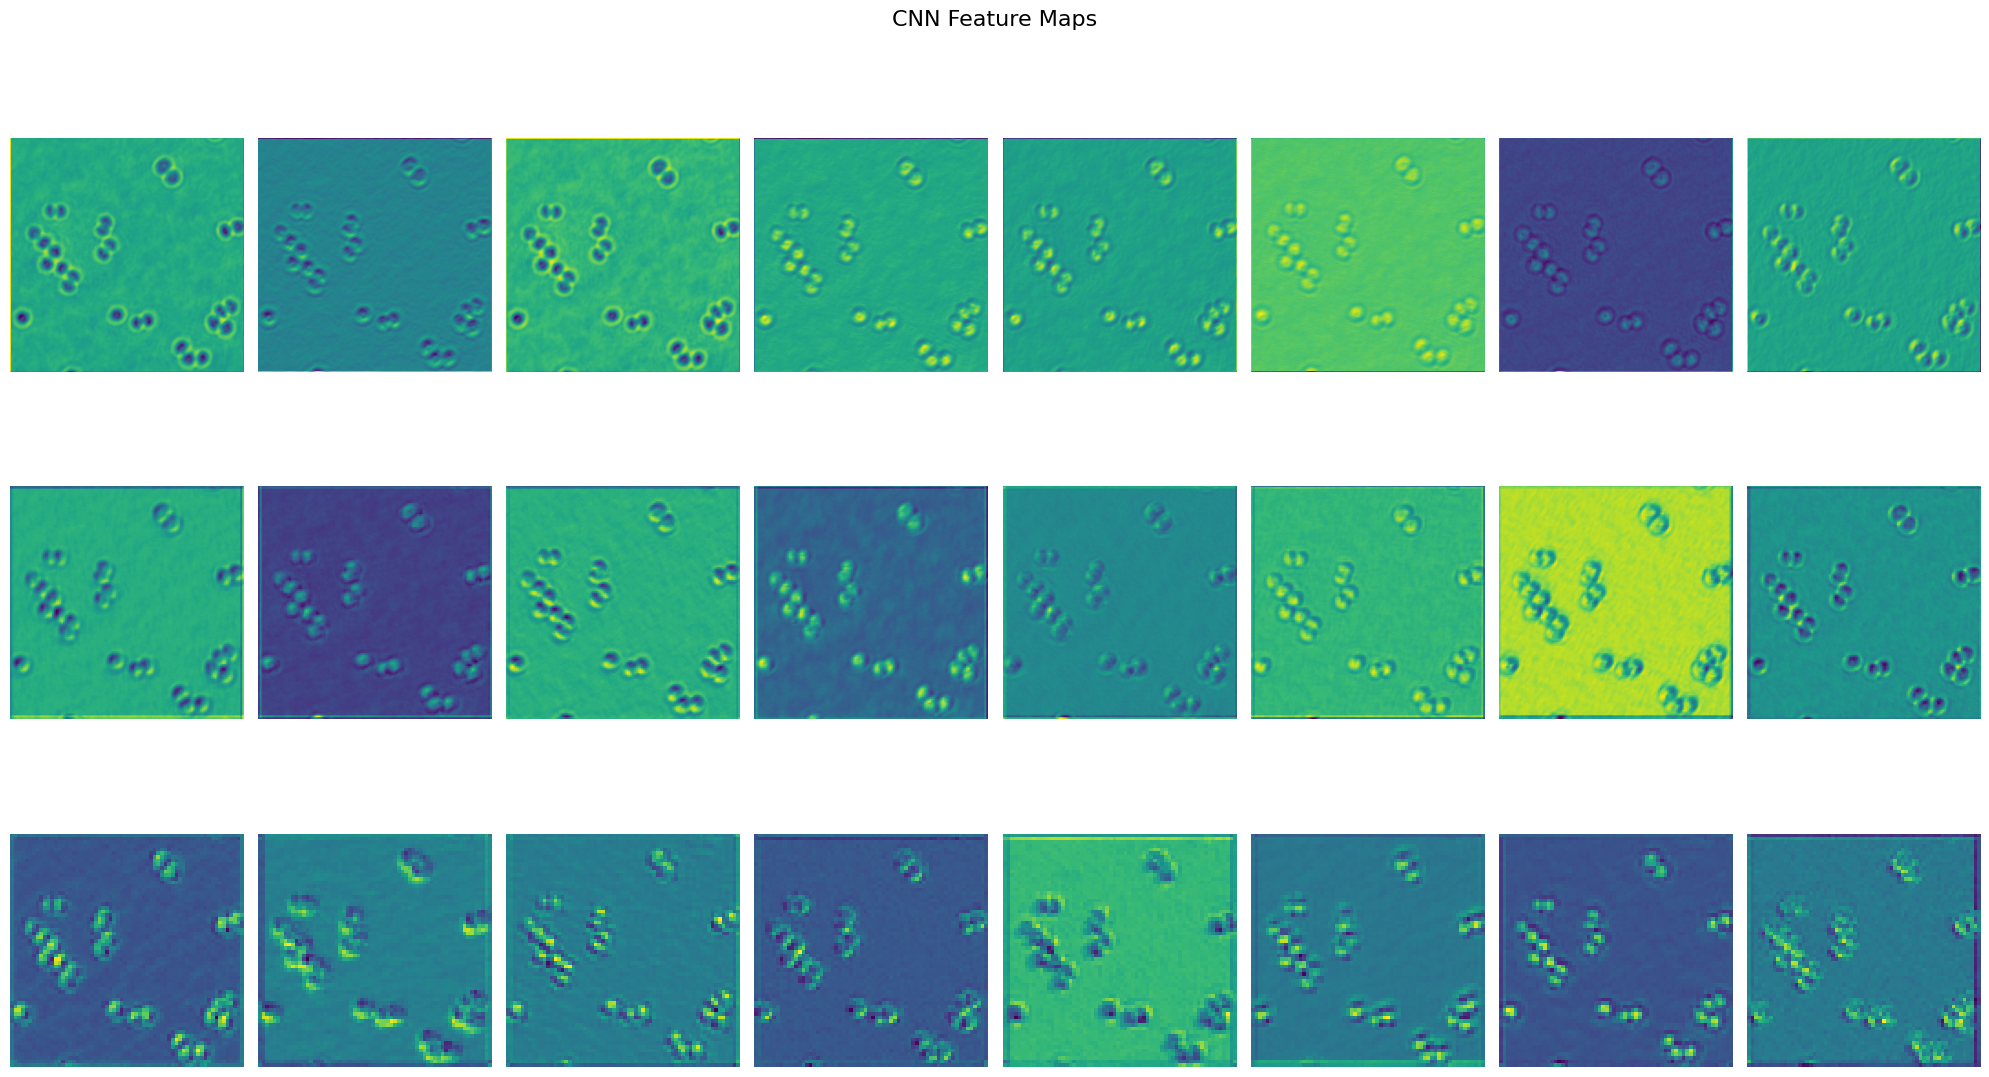

In [120]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the CNN
cnn_extractor = CNNFeatureExtractor(output_channels=64)

# Initialize the Transformer with CNN as backbone
model = SimpleTransformer(img_size=64, patch_size=8, embed_dim=64, num_heads=4, num_layers=4, cnn_extractor=cnn_extractor).to(device)

# Set up hooks for feature map visualization
activations = {}

def hook_fn(module, input, output):
    activations[module] = output.detach()

for name, module in cnn_extractor.named_modules():
    if isinstance(module, nn.Conv2d):
        module.register_forward_hook(hook_fn)

# Train the model
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()
num_epochs = 300
training_loss = []

# Initialize variables
best_loss = float('inf')
best_model_path = "best_model_TransformerCNN_trial.pth"
test_losses = []  # Store test loss per epoch

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_loss = 0.0
    
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    training_loss.append(avg_train_loss)
    
    # Save the model with the best training loss
    if avg_train_loss < best_loss:
        best_loss = avg_train_loss
        torch.save(model.state_dict(), best_model_path)
    
    # Testing phase (evaluation on the test set)
    model.eval()
    total_test_loss = 0.0
    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_test_loss += loss.item()
    
    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    # Print training and testing losses
    print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")
    
    # Visualize predictions after every N epochs
    if (epoch + 1) % 50 == 0:
        with torch.no_grad():
            for images, masks in test_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                visualize_predictions(images, masks, outputs, num_examples=2)
                break  # Visualize only the first batch

# Visualize CNN feature maps after training
def visualize_feature_maps(model, image):
    model.eval()
    with torch.no_grad():
        _ = model(image.unsqueeze(0).to(device))
    
    fig, axs = plt.subplots(len(activations), 8, figsize=(20, 4*len(activations)))
    fig.suptitle("CNN Feature Maps", fontsize=16)
    
    for idx, (layer, activation) in enumerate(activations.items()):
        activation = activation.squeeze().cpu()
        for j in range(min(8, activation.shape[0])):
            axs[idx, j].imshow(activation[j], cmap='viridis')
            axs[idx, j].axis('off')
        axs[idx, 0].set_ylabel(f"Layer {idx+1}")
    
    plt.tight_layout()
    plt.show()

# Get a sample image from test set
sample_image, _ = next(iter(test_loader))
sample_image = sample_image[0]

# Visualize feature maps
visualize_feature_maps(model, sample_image)

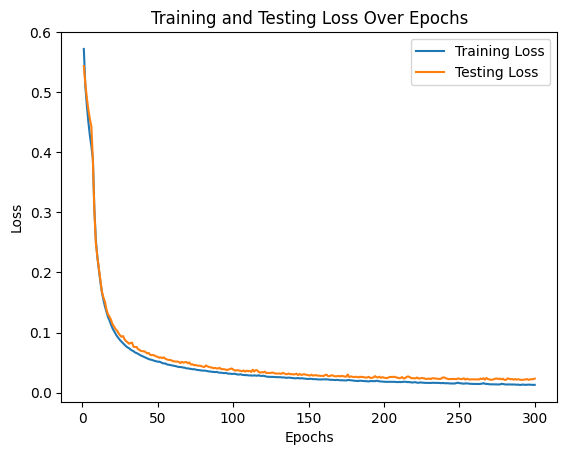

In [121]:
# Plot training vs testing loss
plt.plot(range(1, num_epochs + 1), training_loss, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Testing Loss Over Epochs')
plt.show()


## **Testing**

In [122]:
# Test loader
# Paths to data
brightfield_folder_test = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_2/bacteria_counting/Data/2b/DeepBacs_Data_Segmentation_Staph_Aureus_dataset/brightfield_dataset/test/patches/brightfield'
masks_folder_test = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_2/bacteria_counting/Data/2b/DeepBacs_Data_Segmentation_Staph_Aureus_dataset/brightfield_dataset/test/patches/masks'

# Augmented images
augmented_brightfield_folder_test = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_2/bacteria_counting/Data/2b/DeepBacs_Data_Segmentation_Staph_Aureus_dataset/brightfield_dataset/test/patches/augmented_brightfield_dens_3'
augmented_masks_folder_test = '/projectnb/ec523kb/projects/teams_Fall_2024/Team_2/bacteria_counting/Data/2b/DeepBacs_Data_Segmentation_Staph_Aureus_dataset/brightfield_dataset/test/patches/augmented_masks_dens_3'

# Load brightfield images and masks
original_brightfield_test = load_images(brightfield_folder_test)
original_masks_test = load_images(masks_folder_test, threshold=1)

# Convert images and masks to PyTorch tensors
X_tensor_test = torch.tensor(original_brightfield_test, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
Y_tensor_test = torch.tensor(original_masks_test, dtype=torch.float32).unsqueeze(1)  # Add channel dimension

test_dataset = TensorDataset(X_tensor_test, Y_tensor_test)  # Pairs of images and masks
test_loader_original = DataLoader(test_dataset, batch_size=8, shuffle=False)

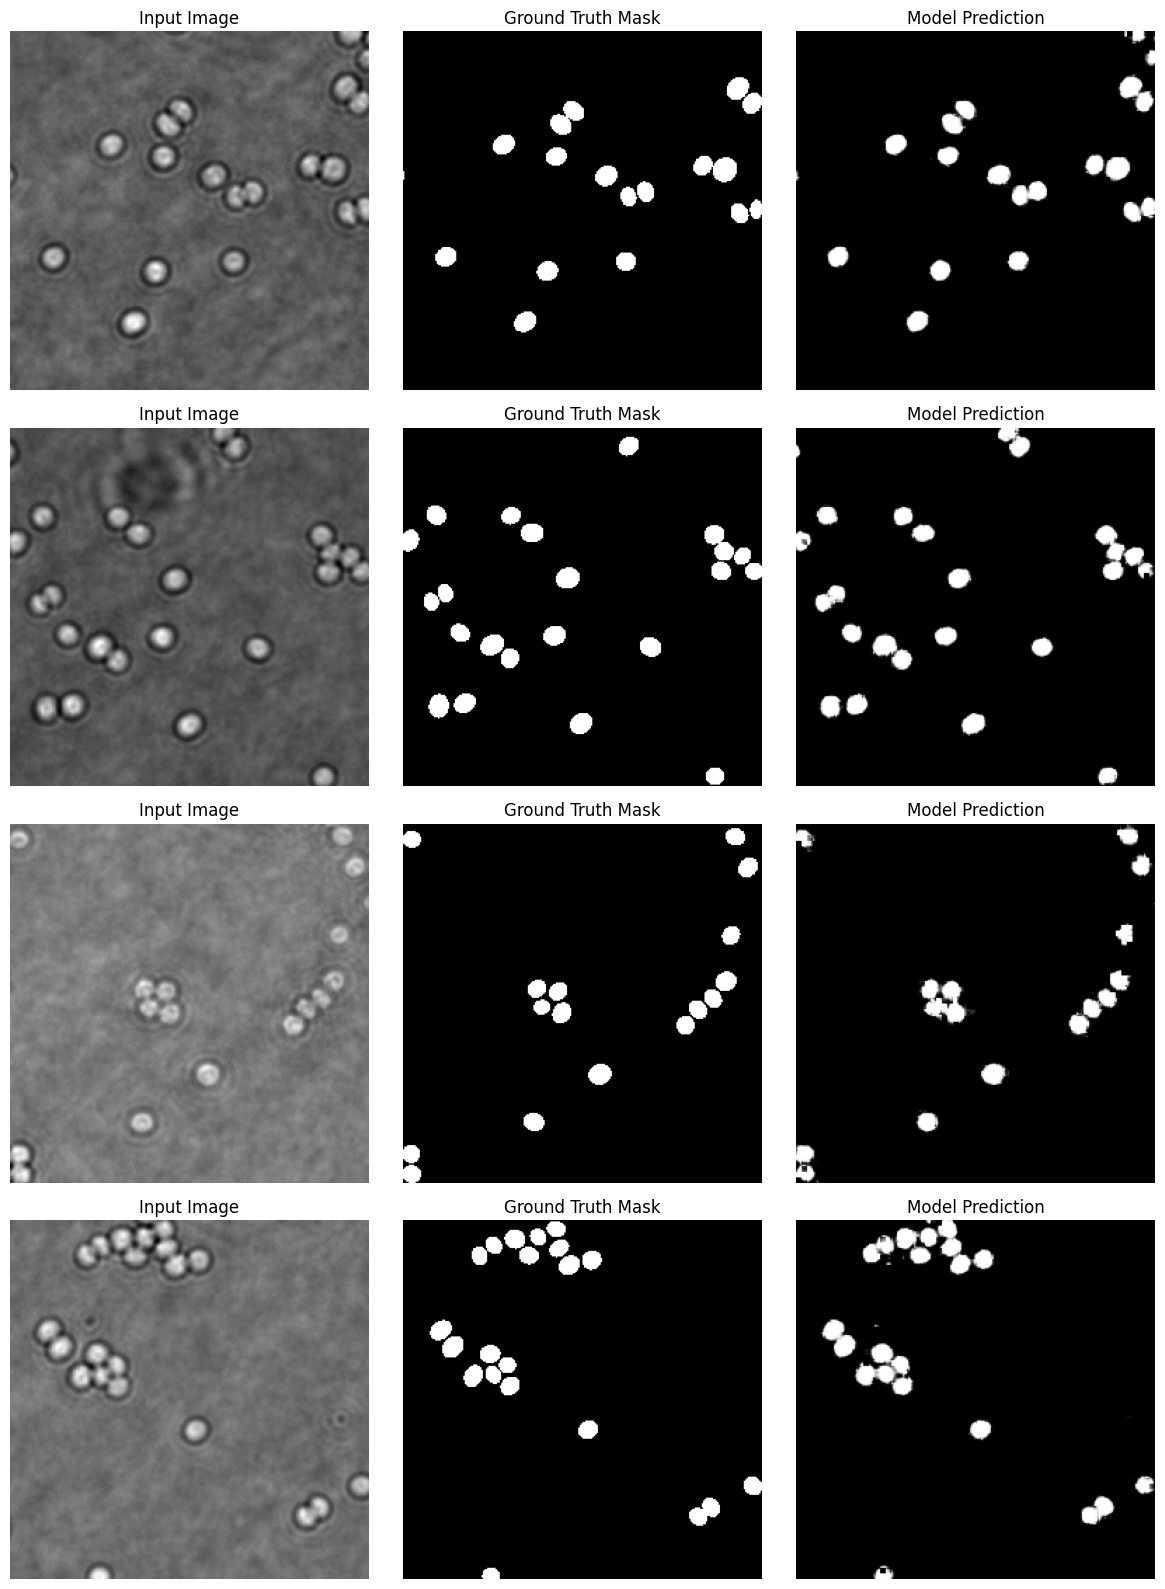

Loss: 0.034026880438129105
Stored all images, masks, and outputs.


In [123]:
# Test Model 

# Initialize lists to store results
all_images = []
all_masks = []
all_outputs = []

model.eval()
total_loss = 0.0


with torch.no_grad():
    for images, masks in test_loader_original:  # Assuming dataloader includes all data
        images, masks = images.to(device), masks.to(device)
        
        # Forward pass
        outputs = model(images)  # Predictions
        loss = criterion(outputs, masks)  # Loss calculation
        total_loss += loss.item()
        
        # Store images, masks, and outputs
        all_images.append(images.cpu())        # Move to CPU to avoid GPU memory issues
        all_masks.append(masks.cpu())
        all_outputs.append(outputs.cpu())
        
    # Visualize a few predictions (optional)
    visualize_predictions(images, masks, outputs, num_examples=4)
        
    # Calculate and print average loss
    avg_loss = total_loss / len(test_loader_original)
    print('Loss:', avg_loss)

# Optional: Concatenate results for easy access
all_images = torch.cat(all_images, dim=0)
all_masks = torch.cat(all_masks, dim=0)
all_outputs = torch.cat(all_outputs, dim=0)

print("Stored all images, masks, and outputs.")


## Segmentation / Bounding Boxes

**Functions**

In [124]:
import torch
import cv2
import numpy as np
from scipy.ndimage import label

def get_bounding_boxes(mask):
    """
    Extract bounding boxes from a binary mask.
    Input:
        mask: Binary mask (H x W), where objects are white (1) and background is black (0).
    Output:
        List of bounding boxes as (x, y, w, h).
    """
    # Convert to numpy and ensure binary format
    mask_np = mask.squeeze().cpu().numpy().astype(np.uint8)  # Shape: H x W
    labeled_mask, num_objects = label(mask_np)  # Label connected components
    print(num_objects)
    
    bounding_boxes = []
    for i in range(1, num_objects + 1):
        obj_mask = (labeled_mask == i).astype(np.uint8)
        contours, _ = cv2.findContours(obj_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            bounding_boxes.append((x, y, w, h))
    
    return bounding_boxes


def compute_overlap(boxA, boxB):
    """
    Compute IoU (Intersection over Union) between two bounding boxes.
    Each box is (x, y, w, h).
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    # Compute the area of intersection
    interArea = max(0, xB - xA) * max(0, yB - yA)
    
    # Compute area of each box
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    
    # Compute IoU
    iou = interArea / float(boxAArea)
    return iou

def draw_bounding_boxes(image, boxes, indices_to_draw=None, color=(0, 255, 0), thickness=2):
    """
    Draw specific bounding boxes on an image.
    Input:
        image: Input mask or image as numpy array (H x W).
        boxes: List of bounding boxes [(x, y, w, h)].
        indices_to_draw: List of indices of boxes to be drawn (e.g., [0, 2, 3]).
                         If None, draw all bounding boxes.
        color: Bounding box color (BGR for OpenCV).
        thickness: Line thickness of the boxes.
    Output:
        Image with specified bounding boxes drawn.
    """
    image = image.copy()
    if len(image.shape) == 2:  # If grayscale, convert to 3-channel
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    # Draw only specified bounding boxes
    if indices_to_draw is None:
        indices_to_draw = range(len(boxes))  # Draw all boxes if none specified
    
    for idx in indices_to_draw:
        if idx < len(boxes):  # Ensure index is within bounds
            x, y, w, h = boxes[idx]
            cv2.rectangle(image, (x, y), (x + w, y + h), color, thickness)
    return image


def calculate_recall(all_masks, all_outputs, overlap_threshold=0.75, indices_to_draw = None):
    """
    Calculate recall and visualize bounding boxes.
    Input:
        all_masks: Tensor of ground truth masks, shape [N, 1, H, W].
        all_outputs: Tensor of predicted masks, shape [N, 1, H, W].
        overlap_threshold: IoU threshold for TP.
    Output:
        Recall value and visualization of bounding boxes.
    """
    total_TP = 0
    total_GT_boxes = 0

    for idx, (gt_mask, pred_mask) in enumerate(zip(all_masks, all_outputs)):
        # Get bounding boxes
        gt_boxes = get_bounding_boxes(gt_mask)
        pred_boxes = get_bounding_boxes(pred_mask)

        total_GT_boxes += len(gt_boxes)
        matched = set()

        # Match predicted boxes to ground truth boxes -- Little Finicky 
        for i, gt_box in enumerate(gt_boxes):
            for j, pred_box in enumerate(pred_boxes):
                if j not in matched: 
                    iou = compute_overlap(gt_box, pred_box)
                    if iou >= overlap_threshold:
                        total_TP += 1
                        matched.add(j)
                        break

        # Visualization
        gt_image = gt_mask.squeeze().cpu().numpy().astype(np.uint8) * 255
        pred_image = pred_mask.squeeze().cpu().numpy().astype(np.uint8) * 255
        


        gt_with_boxes = draw_bounding_boxes(gt_image, gt_boxes, indices_to_draw=indices_to_draw, color=(0, 255, 0))  # Green
        pred_with_boxes = draw_bounding_boxes(pred_image, pred_boxes, indices_to_draw=indices_to_draw, color=(0, 0, 255))  # Red

        
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(gt_with_boxes)
        axes[0].set_title("Ground Truth Bounding Boxes")
        axes[0].axis("off")
        
        axes[1].imshow(pred_with_boxes)
        axes[1].set_title("Predicted Bounding Boxes")
        axes[1].axis("off")
        
        plt.tight_layout()
        plt.show()

    recall = total_TP / total_GT_boxes if total_GT_boxes > 0 else 0.0
    return recall




In [125]:
threshold = 0.5  # Example threshold for binary mask

# Binarize the tensor
all_binarized_outputs = (all_outputs > threshold).float()

print(all_binarized_outputs.shape)

torch.Size([20, 1, 256, 256])


22
25


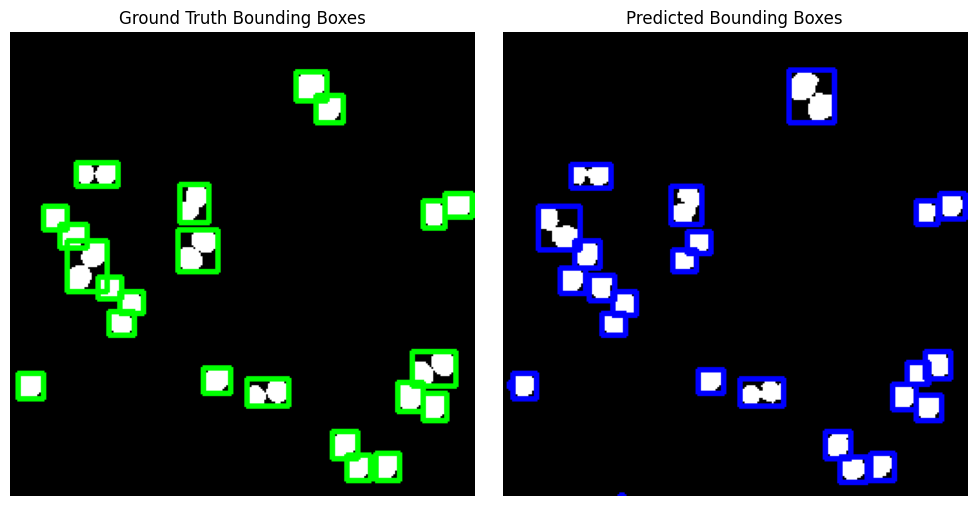

18
25


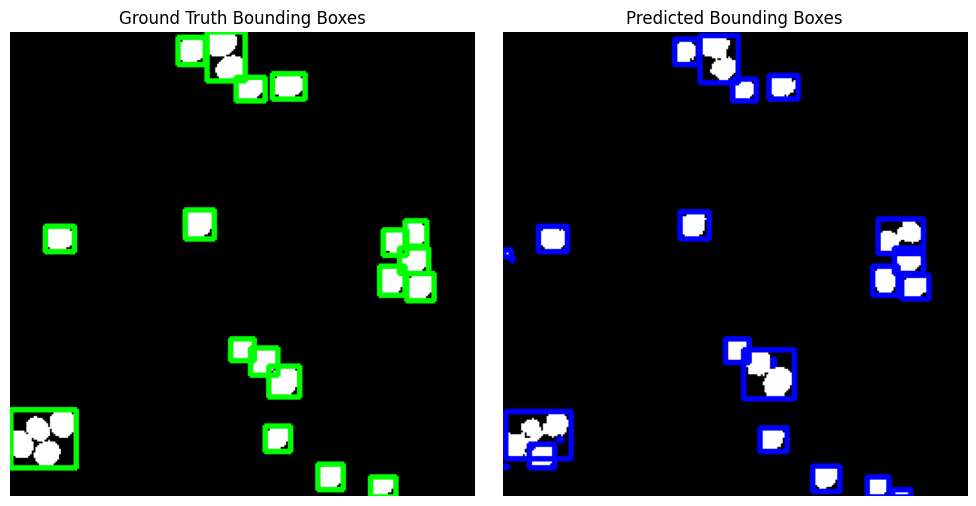

19
27


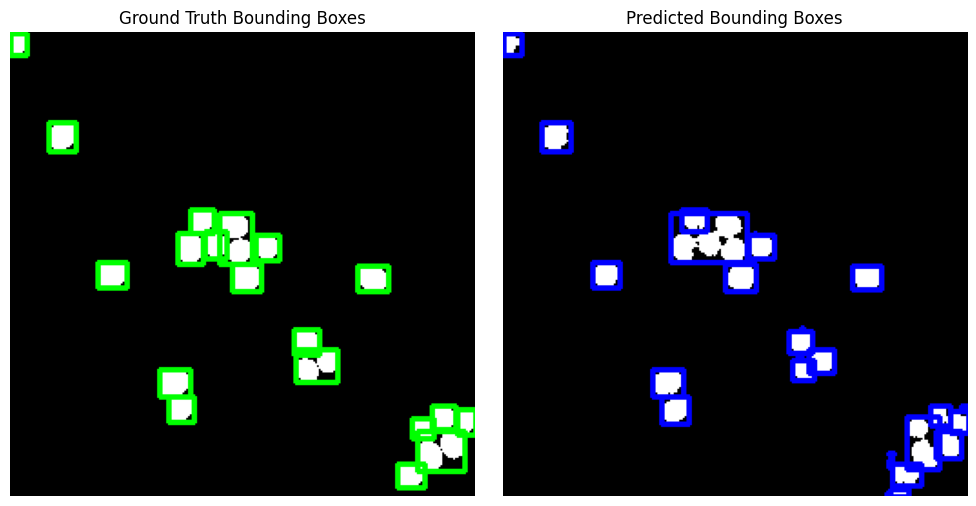

13
12


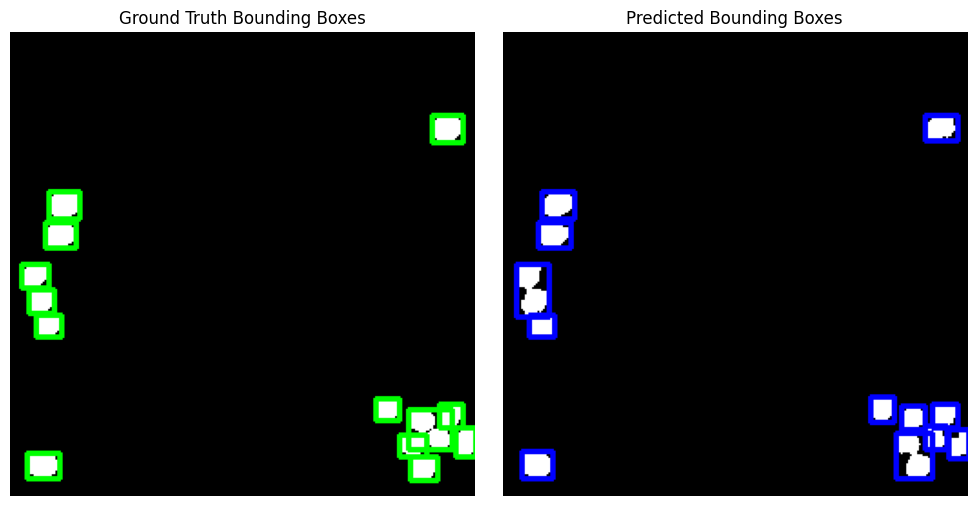

22
23


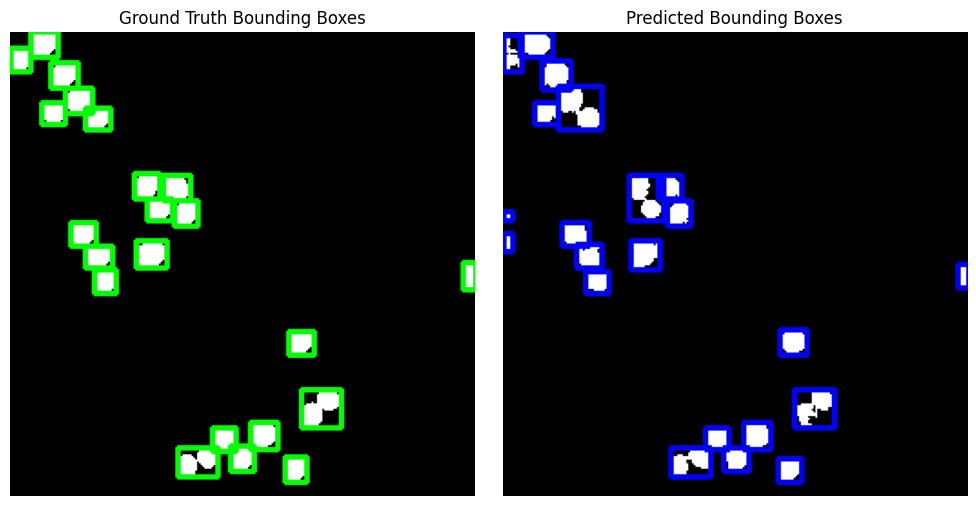

15
13


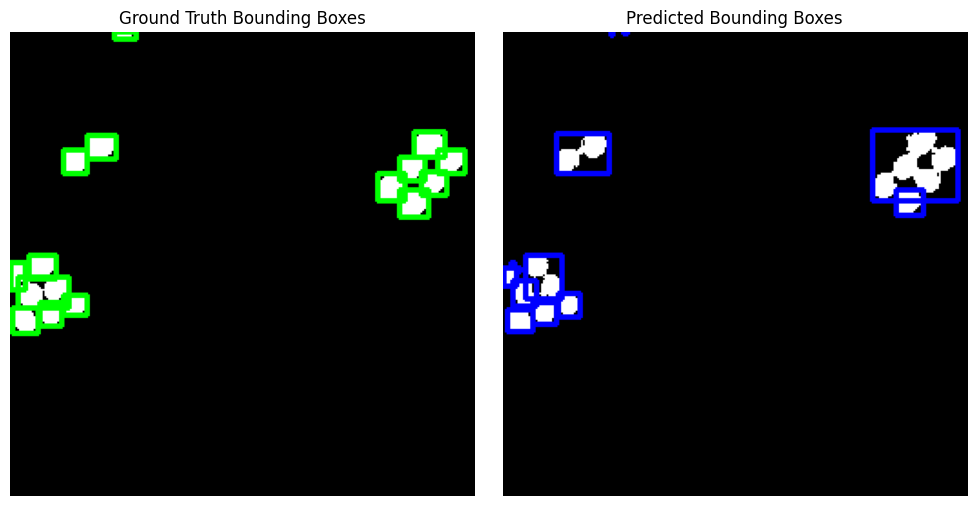

46
40


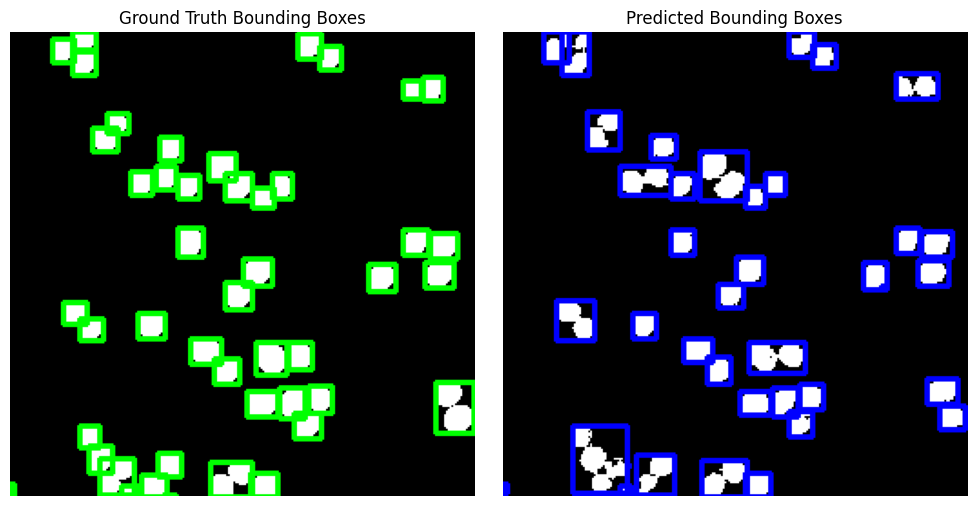

29
33


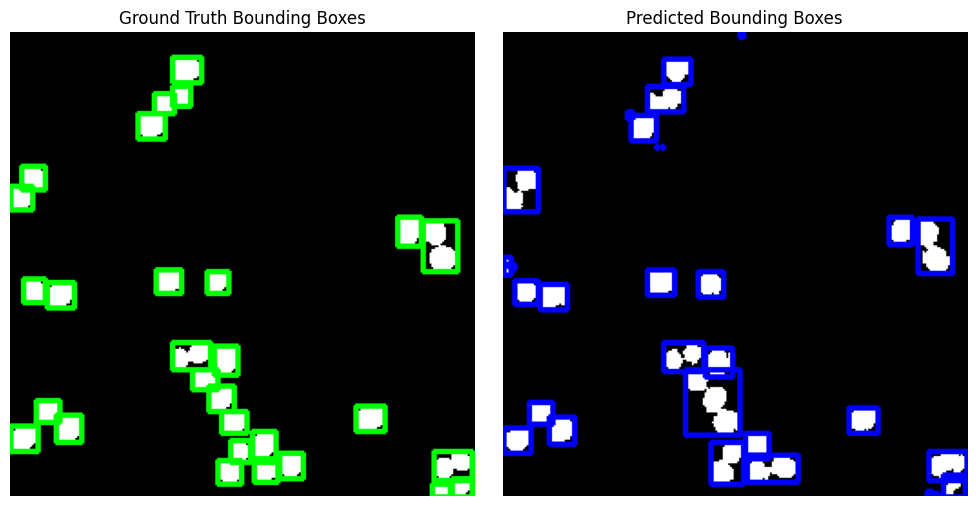

20
33


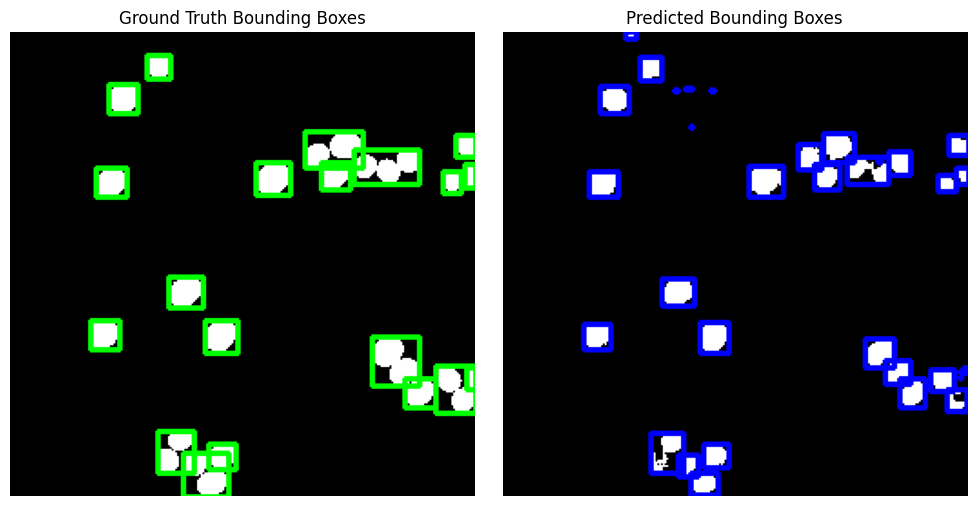

15
23


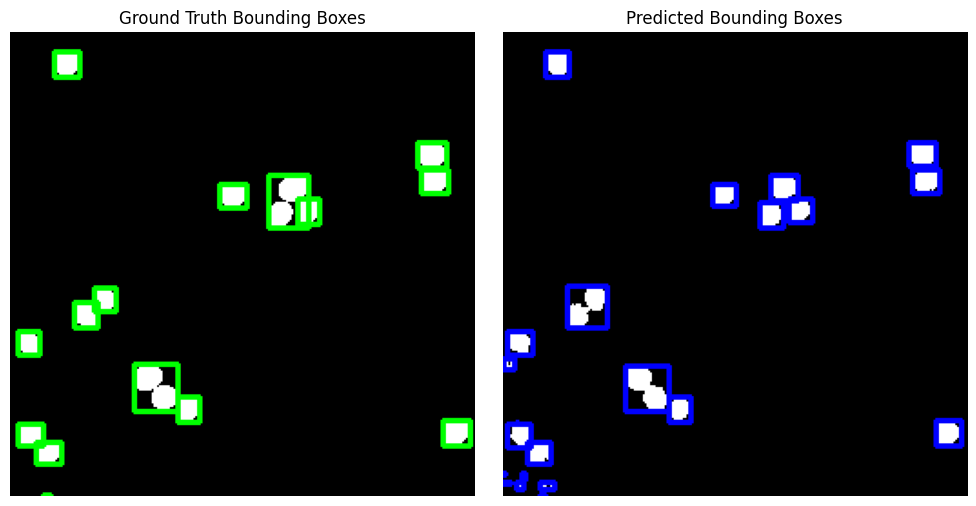

14
18


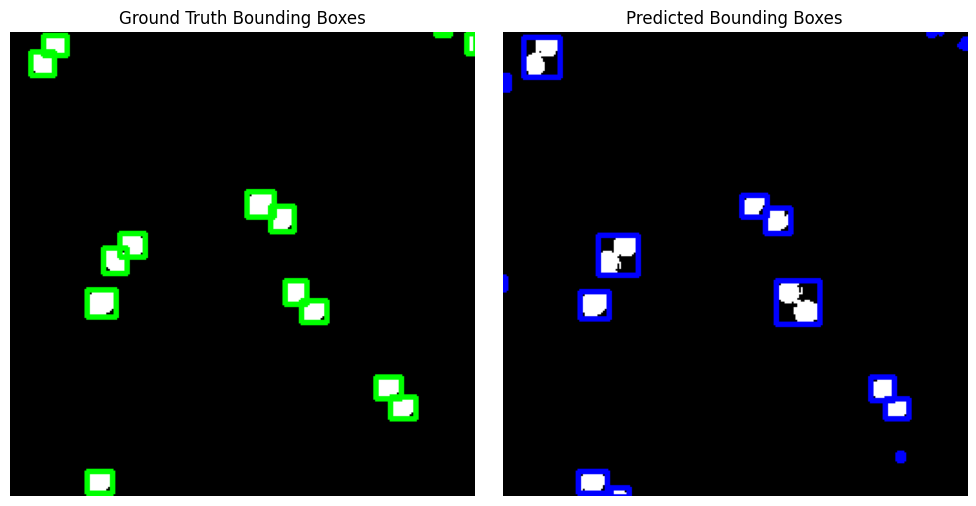

21
31


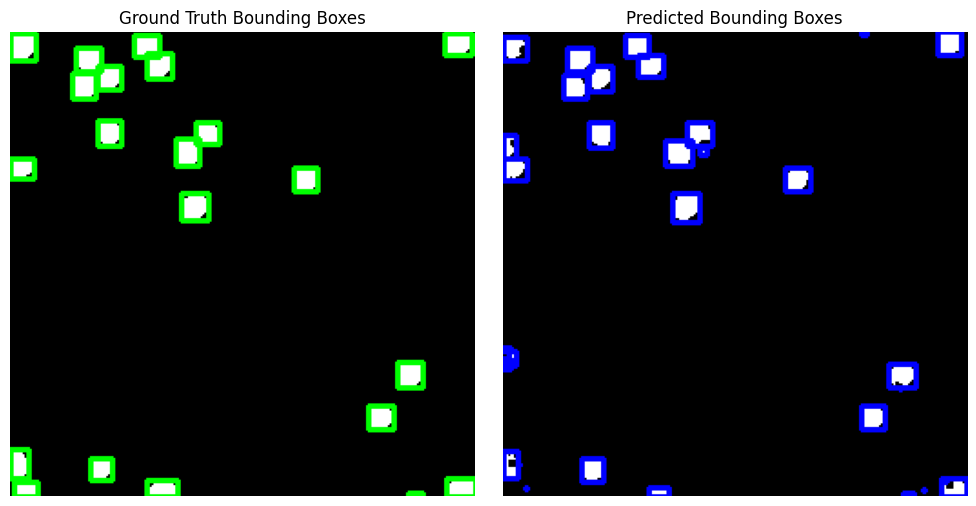

18
19


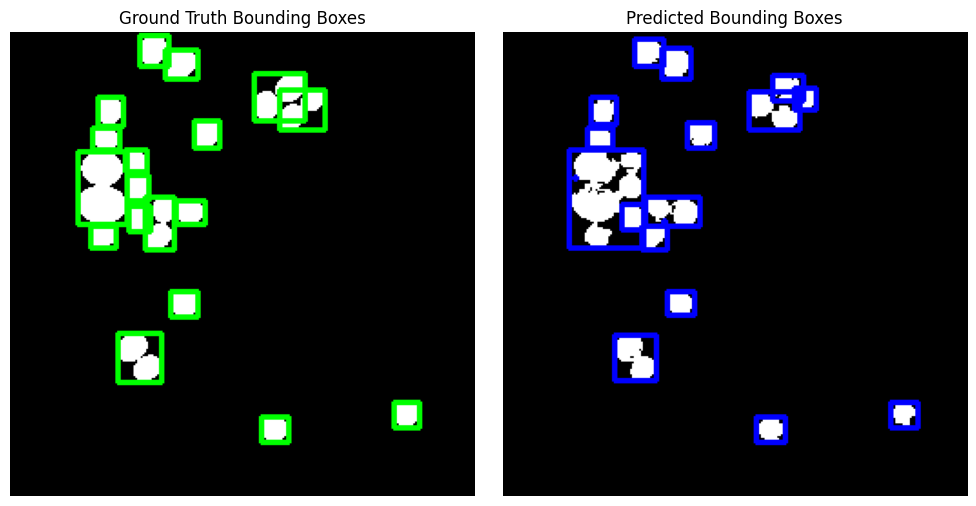

31
30


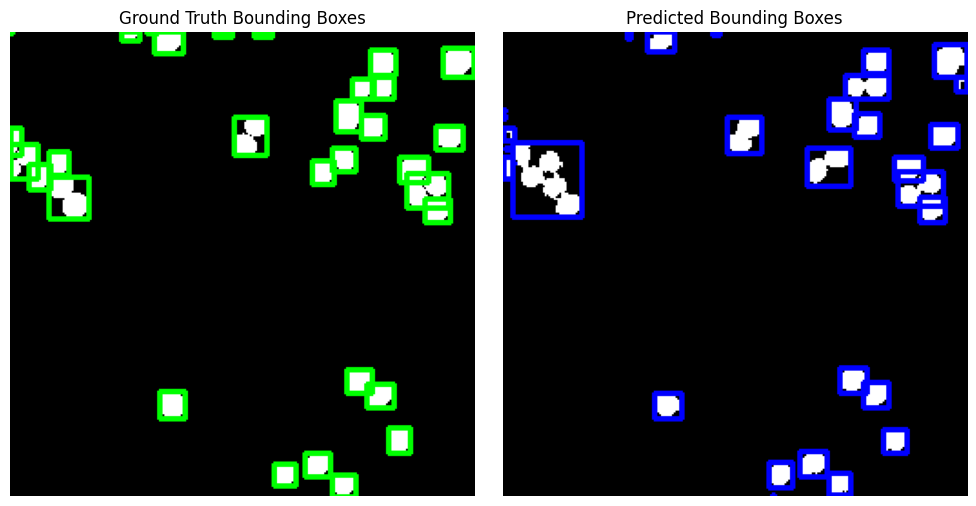

19
41


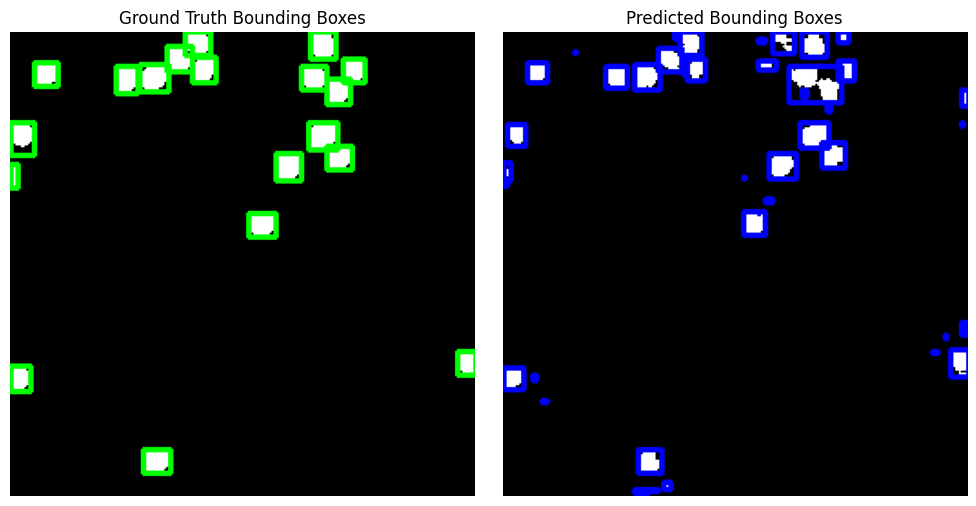

48
48


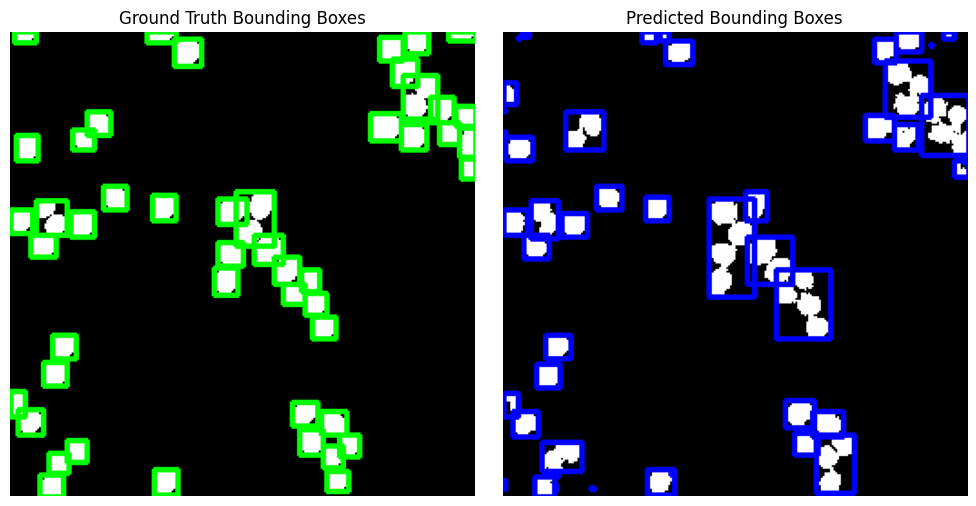

16
19


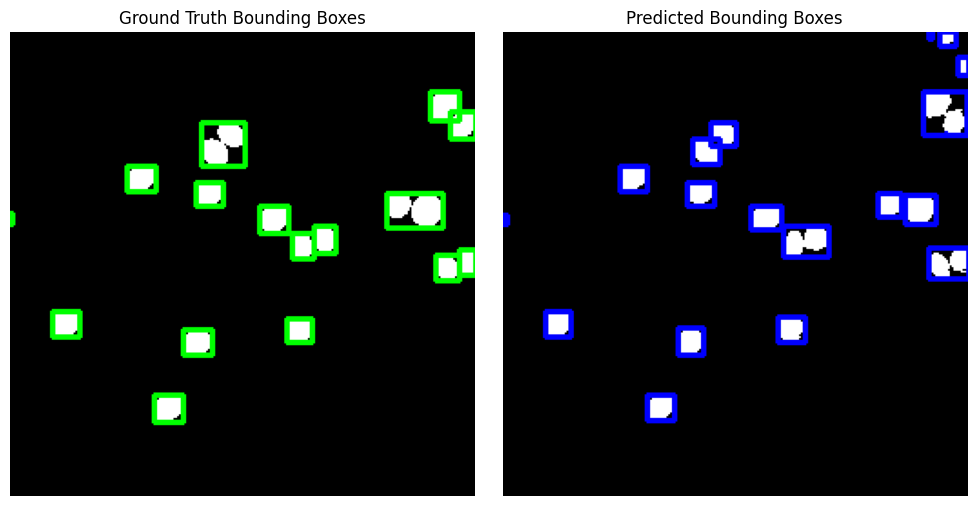

21
20


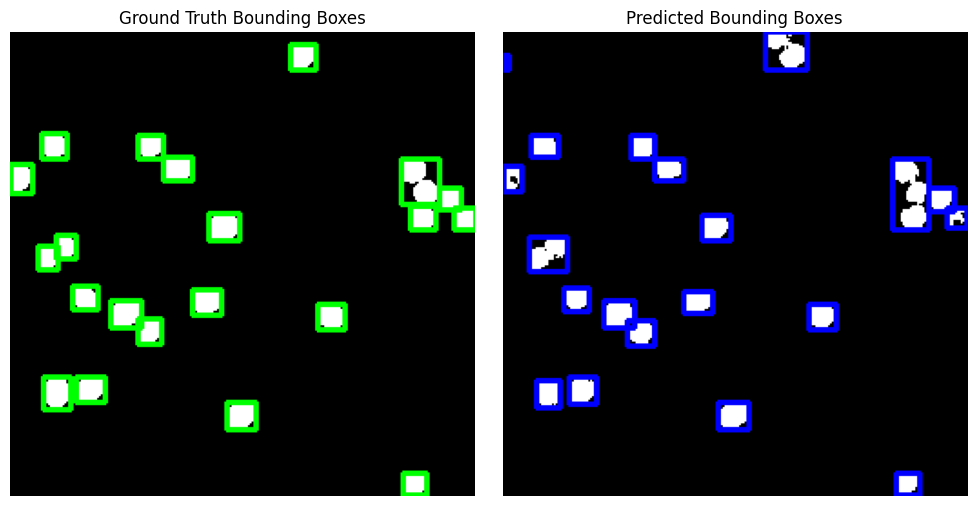

16
16


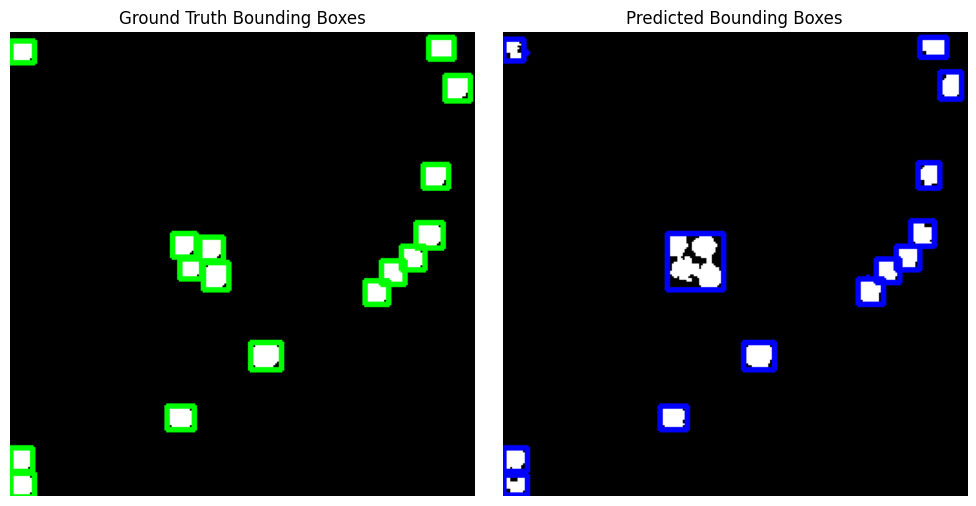

20
19


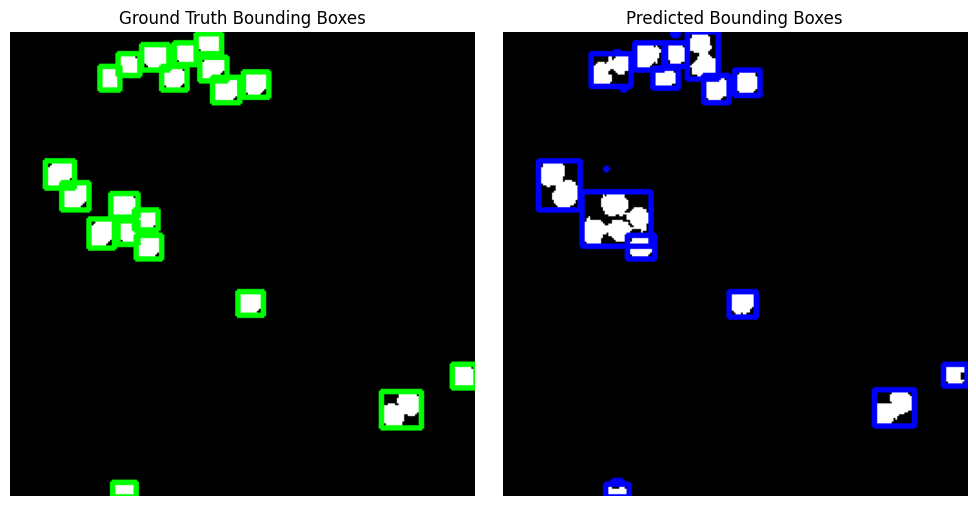

Recall: 0.7156


In [126]:
recall = calculate_recall(all_masks, all_binarized_outputs, overlap_threshold=0.75, indices_to_draw = None)
print(f"Recall: {recall:.4f}")